# Importing Libraries

In [0]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os.path
resume_weights = "/content/drive/My Drive/checkpoint_2.pth.tar"
best_accuracy = torch.FloatTensor([0])
start_epoch = 0

# Preparing the data

In [0]:
torch.manual_seed(5)
np.random.seed(5)

In [0]:

transform= transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = data.DataLoader(mnist_trainset, batch_size=64, shuffle=True, num_workers=2)
mnist_testset = datasets.MNIST(root='./data',train=False, download= True, transform=transform)
mnist_testloader = data.DataLoader(mnist_testset, batch_size= 64, shuffle= True, num_workers=2)


In [39]:
len(mnist_trainset)

60000

In [40]:
len(mnist_testset)

10000

In [0]:
# pytorch's tensor , tensor's 4 dimension (batch-size, no.of channels, height, width)....when looking at a particular image batch size is understood to be 1
# matplotlib wants array's dimension (height, width, channels)

# Looking at some images of dataset

torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64])


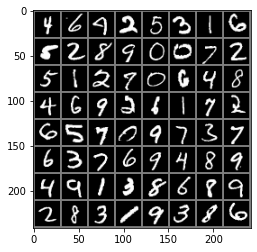

[tensor(4)][tensor(6)][tensor(4)][tensor(2)][tensor(5)][tensor(3)][tensor(1)][tensor(6)][tensor(5)][tensor(2)][tensor(8)][tensor(9)][tensor(0)][tensor(0)][tensor(7)][tensor(2)][tensor(5)][tensor(1)][tensor(2)][tensor(7)][tensor(0)][tensor(6)][tensor(4)][tensor(8)][tensor(4)][tensor(6)][tensor(9)][tensor(2)][tensor(6)][tensor(1)][tensor(7)][tensor(2)][tensor(6)][tensor(5)][tensor(7)][tensor(0)][tensor(9)][tensor(7)][tensor(3)][tensor(7)][tensor(6)][tensor(3)][tensor(7)][tensor(6)][tensor(9)][tensor(4)][tensor(8)][tensor(9)][tensor(4)][tensor(9)][tensor(1)][tensor(3)][tensor(8)][tensor(6)][tensor(8)][tensor(9)][tensor(2)][tensor(8)][tensor(3)][tensor(1)][tensor(9)][tensor(3)][tensor(8)][tensor(6)]


In [42]:
def im1show(img):
  img=img/2 + 0.5   # unnormalize
  npimg= img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()
print(images.size())
print(images.shape)
print(labels.size())

im1show(torchvision.utils.make_grid(images))

print(''.join('%5s' % [labels[j]] for j in range(64)))


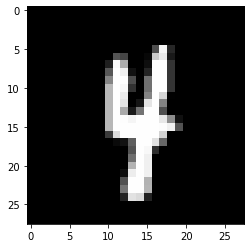

In [43]:
im1show(torchvision.utils.make_grid(images[0]))

# Another Approach

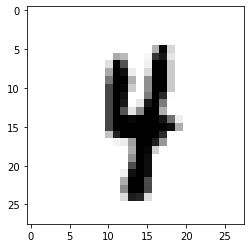

In [44]:
seed=5
torch.manual_seed(seed)
np.random.seed(seed)

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

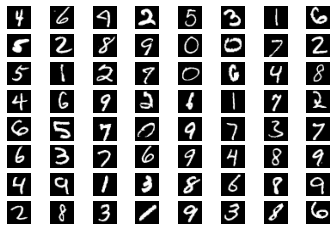

In [45]:
seed=5
torch.manual_seed(seed)
np.random.seed(seed)

dataiter = iter(mnist_trainloader)
images, labels = dataiter.next()

for i in range(64):
  plt.subplot(8,8,i+1)
  plt.axis('off')
  plt.imshow(images[i].numpy().squeeze(),cmap='gray')

# Making Model

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,32,5)
    self.pool1 = nn.MaxPool2d(2)
    self.dropout1 = nn.Dropout2d(p=0.2)
    self.fc1 = nn.Linear(32*12*12,128)
    self.fc2 = nn.Linear(128,10)
    

  def forward(self,x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.dropout1(x)
    x = x.view(-1, 32*12*12)    # first element is batchsize , we can use -1 as well, second element is number of features
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x),dim=1)
    
    return x

net = Net()


# Defining Loss fn and Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,betas=(0.9,0.999) )

# Saving and Resuming Check Point

In [0]:
def save_checkpoint(state, is_best , file_name = "/content/drive/My Drive/checkpoint_2.pth.tar"):
  if is_best:
    print("Saving a new best")

    torch.save (state, file_name)

  else:
    print("Validation accuracy did not improve")


In [49]:
if os.path.isfile(resume_weights):
  checkpoint = torch.load(resume_weights)
  start_epoch = checkpoint['epoch']
  best_accuracy = checkpoint['best_accuracy']

  net.load_state_dict(checkpoint['state_dict'])

  print('Loaded checkpoint{} trained for{} epoch with {:.4} % test_accuracy'.format(resume_weights,
      checkpoint['epoch'],100*best_accuracy.numpy()[0]))
                                                                                 
                                                                                  

Loaded checkpoint/content/drive/My Drive/checkpoint_2.pth.tar trained for1 epoch with 9.837e+03 % test_accuracy


# Training the Network

In [0]:
def eval():
  net.eval

  correct = 0
  total = 0
  with torch.no_grad():
    for data in mnist_testloader:
      images,labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (labels==predicted).sum().item()
  
  return 100*correct/total 



In [51]:
for epoch in range(2):

  correct = 0
  total = 0

  running_loss = 0.0
  for i, data in enumerate(mnist_trainloader,0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    if i % 100 == 99:
      print('[%d , %4d] loss: %.3f  acc:%.3f %%'% 
            (epoch+1, i+1, running_loss/100, 100*correct/total))
      running_loss = 0.0

  acc_test = eval()
  acc_test = torch.FloatTensor([acc_test])
  is_best = bool(acc_test.numpy()>best_accuracy.numpy())
  best_accuracy = torch.FloatTensor(max(acc_test.numpy(),best_accuracy.numpy()))
  save_checkpoint({
      'epoch': start_epoch + epoch , 
      'state_dict': net.state_dict(), 'best_accuracy': best_accuracy}, is_best)

  print('Test_Accuracy : %.2f %%' % (
      acc_test))

print('Finished Training')

  


[1 ,  100] loss: 0.046  acc:98.422 %
[1 ,  200] loss: 0.048  acc:98.461 %
[1 ,  300] loss: 0.059  acc:98.417 %
[1 ,  400] loss: 0.046  acc:98.457 %
[1 ,  500] loss: 0.047  acc:98.459 %
[1 ,  600] loss: 0.053  acc:98.432 %
[1 ,  700] loss: 0.044  acc:98.473 %
[1 ,  800] loss: 0.059  acc:98.459 %
[1 ,  900] loss: 0.039  acc:98.488 %
Saving a new best
Test_Accuracy : 98.38 %
[2 ,  100] loss: 0.029  acc:99.109 %
[2 ,  200] loss: 0.033  acc:99.062 %
[2 ,  300] loss: 0.023  acc:99.125 %
[2 ,  400] loss: 0.028  acc:99.137 %
[2 ,  500] loss: 0.032  acc:99.097 %
[2 ,  600] loss: 0.026  acc:99.115 %
[2 ,  700] loss: 0.030  acc:99.114 %
[2 ,  800] loss: 0.031  acc:99.113 %
[2 ,  900] loss: 0.031  acc:99.097 %
Saving a new best
Test_Accuracy : 98.48 %
Finished Training


# Test the network on test data

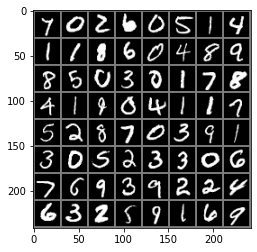

GroundTruth: tensor(7) tensor(0) tensor(2) tensor(6) tensor(0) tensor(5) tensor(1) tensor(4) tensor(1) tensor(1) tensor(8) tensor(6) tensor(0) tensor(4) tensor(8) tensor(9) tensor(8) tensor(5) tensor(0) tensor(3) tensor(0) tensor(1) tensor(7) tensor(8) tensor(4) tensor(1) tensor(9) tensor(0) tensor(4) tensor(1) tensor(1) tensor(7) tensor(5) tensor(2) tensor(8) tensor(7) tensor(0) tensor(3) tensor(9) tensor(1) tensor(3) tensor(0) tensor(5) tensor(2) tensor(3) tensor(3) tensor(0) tensor(6) tensor(7) tensor(6) tensor(9) tensor(3) tensor(9) tensor(2) tensor(2) tensor(4) tensor(6) tensor(3) tensor(2) tensor(5) tensor(9) tensor(1) tensor(6) tensor(9)


In [52]:
dataiter = iter(mnist_testloader)
images,labels = dataiter.next()

im1show(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%1s' % labels[j] for j in range(64)))

In [0]:
outputs = net(images)

In [54]:
_ , predicted = torch.max(outputs,1)

print('predicted:' , ''.join ('%2s' % predicted[j] for j in range(64)))


predicted: tensor(7)tensor(0)tensor(2)tensor(6)tensor(0)tensor(5)tensor(1)tensor(4)tensor(1)tensor(1)tensor(8)tensor(6)tensor(0)tensor(4)tensor(8)tensor(9)tensor(8)tensor(5)tensor(0)tensor(3)tensor(0)tensor(1)tensor(7)tensor(8)tensor(4)tensor(1)tensor(4)tensor(0)tensor(4)tensor(1)tensor(1)tensor(7)tensor(5)tensor(2)tensor(8)tensor(7)tensor(0)tensor(3)tensor(9)tensor(1)tensor(3)tensor(0)tensor(5)tensor(2)tensor(3)tensor(3)tensor(0)tensor(6)tensor(7)tensor(6)tensor(9)tensor(3)tensor(9)tensor(2)tensor(2)tensor(4)tensor(6)tensor(3)tensor(2)tensor(8)tensor(9)tensor(1)tensor(6)tensor(9)
